# Import required dependencies

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Softmax, Dropout
from keras import backend as K
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

import numpy as np
import numpy.random as random
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline

Using TensorFlow backend.
/Users/arw/anaconda3/envs/text-analytics/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/arw/anaconda3/envs/text-analytics/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/arw/anaconda3/envs/text-analytics/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

# Define constants
It is usually a good idea to have common constants defined up top, so we can easily change them as needed

In [2]:
UNK_TOKEN = '__unk__'
MAX_SEQUENCE_LENGTH = 50
VOCAB_SIZE = 15000

# Read data

In [3]:
import csv

emotions = {
	"anger":0,
	"boredom":1,
	"empty":2,
	"enthusiasm":3,
	"fun":4,
	"happiness":5,
	"hate":6,
	"love":7,
	"neutral":8,
	"relief":9,
	"sadness":10,
	"surprise":11,
	"worry": 12
}

emotions_stats = {k: 0 for k in emotions}
data_lines = []
num_classes = len(emotions)
with open('data/sentiment/text_emotion.csv', newline='') as f:
    reader = csv.reader(f)
    for row_idx, row in enumerate(reader):
        # Ignore first row since its a header row in the dataset
        if row_idx == 0: continue
            
        # Append a tuple of (emotion_index, text)
        if row[1] in emotions:
            data_lines.append((emotions[row[1]],row[3]))
            emotions_stats[row[1]] += 1
print("Read %d lines"%(len(data_lines)))

Read 40000 lines


## Train/Dev/Test splits
To see if our model actually learns, we divide all of the data into these three splits (70-10-20 split for train-dev-test)

In [4]:
# Send random seed for reproducible results
# random.seed(5) # Gets test set
random.seed(2019) # Gets new blind test set
random.shuffle(data_lines)

total_instances = len(data_lines)
num_train_instances = int(0.7 * total_instances)
num_dev_instances = int(0.1 * total_instances)
num_test_instances = int(0.2 * total_instances)

train = data_lines[:num_train_instances]
dev = data_lines[num_train_instances:num_train_instances + num_dev_instances]
test = data_lines[num_train_instances + num_dev_instances:num_train_instances + num_dev_instances + num_test_instances]

## Preprocessing 

In [5]:
# Separate out labels and data
def get_data_labels(lines):
    labels, data = [], []
    for line in lines:
        l, d = line
        labels.append(int(l))
        data.append(d)
    
    return labels, data

train_labels, train_data = get_data_labels(train)
dev_labels, dev_data = get_data_labels(dev)
test_labels, test_data = get_data_labels(test)
print(train_labels[:10])
print(train_data[:10])

[5, 12, 7, 7, 4, 5, 9, 5, 11, 12]
['Good morning  ready to start this week.', 'Suffering from  Hemorrhoids.', 'sizzling outside. Work inside = double', 'Brad Fastings is my favorite person to hang out with from 12 AM to 5 AM', 'shake shake shake shake shake it', "@DavidArchie I'm watching some of your videos in YouTube. You're funny David.  Oh and TALENTED of course!", 'Finished up cleaning my desk at least. . . office is looking empty. . .almost time to be in the car for 1 1/2!  #fb', 'just got home from a nice party, just not tired yet', 'Listen to Back Around by @ddlovato ...love this song. Meet @TiniOlsen tomorrow ^.^ But we canï¿½t go swimming  Sorry', "I'm yet holdin' on."]


In [6]:
# Preprocess data
def preprocess(data):
    # Tokenize (separate by space, punctuation etc) and lowercase all data
    return [word_tokenize(t.lower()) for t in data]

train_data = preprocess(train_data)
dev_data = preprocess(dev_data)
test_data = preprocess(test_data)
print(train_data[:10])

[['good', 'morning', 'ready', 'to', 'start', 'this', 'week', '.'], ['suffering', 'from', 'hemorrhoids', '.'], ['sizzling', 'outside', '.', 'work', 'inside', '=', 'double'], ['brad', 'fastings', 'is', 'my', 'favorite', 'person', 'to', 'hang', 'out', 'with', 'from', '12', 'am', 'to', '5', 'am'], ['shake', 'shake', 'shake', 'shake', 'shake', 'it'], ['@', 'davidarchie', 'i', "'m", 'watching', 'some', 'of', 'your', 'videos', 'in', 'youtube', '.', 'you', "'re", 'funny', 'david', '.', 'oh', 'and', 'talented', 'of', 'course', '!'], ['finished', 'up', 'cleaning', 'my', 'desk', 'at', 'least', '.', '.', '.', 'office', 'is', 'looking', 'empty', '.', '.', '.almost', 'time', 'to', 'be', 'in', 'the', 'car', 'for', '1', '1/2', '!', '#', 'fb'], ['just', 'got', 'home', 'from', 'a', 'nice', 'party', ',', 'just', 'not', 'tired', 'yet'], ['listen', 'to', 'back', 'around', 'by', '@', 'ddlovato', '...', 'love', 'this', 'song', '.', 'meet', '@', 'tiniolsen', 'tomorrow', '^.^', 'but', 'we', 'canï¿½t', 'go', 's

## Create vocabulary

In [7]:
# Prepare vocabulary
full_vocab = dict()
for instance in train_data:
    for token in instance:
        full_vocab[token] = 1 + full_vocab.get(token, 0)

# Sort vocabulary by occurence
sorted_vocab = sorted(full_vocab.keys(), key=lambda word: -full_vocab[word])

# Print some samples
print("Vocabulary size: %d"%(len(sorted_vocab)))
print("Most frequent tokens")
for i in range(10):
    print("\t%s: %d"%(sorted_vocab[i], full_vocab[sorted_vocab[i]]))
print("Least frequent tokens")
for i in range(1,11):
    print("\t%s: %d"%(sorted_vocab[-i], full_vocab[sorted_vocab[-i]]))

# We can choose to limit the vocab_size here to only a portion of the original vocab,
# i.e. ignore infrequent tokens to save on memory
vocab_size = VOCAB_SIZE
    
# Create final vocab
word2idx = {w: idx for idx, w in enumerate(sorted_vocab[:vocab_size])}
idx2word = {idx: w for idx, w in enumerate(sorted_vocab[:vocab_size])}


word2idx[UNK_TOKEN] = vocab_size
idx2word[vocab_size] = UNK_TOKEN
vocab_size = vocab_size + 1

Vocabulary size: 40815
Most frequent tokens
	i: 16537
	!: 15530
	@: 14237
	.: 14166
	to: 10032
	the: 9059
	,: 8609
	a: 6767
	my: 5617
	you: 5388
Least frequent tokens
	zzerbe: 1
	goooooodmorning: 1
	nawarii22: 1
	easports: 1
	raczilla: 1
	spashed: 1
	kristanmarie: 1
	dbvictoria: 1
	theka: 1
	hyd: 1


## Filter text based on vocabulary
We will now have to replace words we do not have in the vocabulary with a special token, `__unk__` in this case

In [8]:
train_data = [[t if t in word2idx else UNK_TOKEN for t in instance] for instance in train_data]
dev_data = [[t if t in word2idx else UNK_TOKEN for t in instance] for instance in dev_data]
test_data = [[t if t in word2idx else UNK_TOKEN for t in instance] for instance in test_data]

print("Number of tokens filtered out as unknown:")
print("Train: %d/%d"%(len([1 for instance in train_data for t in instance if t == UNK_TOKEN]), sum([len(i) for i in train_data])))
print("Dev: %d/%d"%(len([1 for instance in dev_data for t in instance if t == UNK_TOKEN]), sum([len(i) for i in dev_data])))
print("Test: %d/%d"%(len([1 for instance in test_data for t in instance if t == UNK_TOKEN]), sum([len(i) for i in test_data])))

Number of tokens filtered out as unknown:
Train: 25815/457524
Dev: 5264/65711
Test: 10569/131644


# Prepare data in tensor form
Our keras models finally take tensors as input and labels, so we need to modify our data to fit this form

In [9]:
## data_to_tensor
# Given a list of instances, where each instance is a list of tokens,
# this function does the following:
# 1: Replace each token with its corresponding index
# 2: Pad sequences to MAX_SEQUENCE_LENGTH (or truncate them if longer)
#       Padding is done with a unique element, in this case `vocab_size`
#       The network will learn that this unique element is padding and does not
#        mean anything semantically
# 3: Package everything nicely as a NUM_INSTANCES x MAX_SEQUENCE_LENGTH matrix
def data_to_tensor(data):
    # First convert from words to indices
    idx_data = [[word2idx[t] for t in instance] for instance in data]
    
    # Create numpy representation
    return pad_sequences([np.array(d) for d in idx_data], maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', padding='pre', truncating='pre', value=vocab_size)

X_train = data_to_tensor(train_data)
y_train = to_categorical(np.array(train_labels, dtype=np.int))

X_dev = data_to_tensor(dev_data)
y_dev = to_categorical(np.array(dev_labels, dtype=np.int))

X_test = data_to_tensor(test_data)
y_test = to_categorical(np.array(test_labels, dtype=np.int))

vocab_size = vocab_size + 1 # Add 1 for the padding token

In [10]:
def idx_to_bow(data):
    data_bow = np.zeros((data.shape[0], vocab_size)) 
    for i in range(data.shape[1]):
        data_bow[np.arange(data.shape[0]), data[:, i]] = 1
    return data_bow

X_train_bow = idx_to_bow(X_train)
X_dev_bow = idx_to_bow(X_dev)
X_test_bow = idx_to_bow(X_test)

# Model Definition

In [11]:
model = Sequential()
model.add(Dense(25, input_shape=(vocab_size,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(len(emotions)))
model.add(Softmax())
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                375075    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                663       
_________________________________________________________________
softmax_1 (Softmax)          (None, 13)               

In [12]:
model.fit(X_train_bow, y_train, epochs=10, validation_data=(X_dev_bow, y_dev))


Train on 28000 samples, validate on 4000 samples
Epoch 1/10
28000/28000 [==============================] - 16s 560us/step - loss: 2.0493 - acc: 0.2954 - val_loss: 1.8730 - val_acc: 0.3602
Epoch 2/10
28000/28000 [==============================] - 14s 503us/step - loss: 1.7912 - acc: 0.3962 - val_loss: 1.8789 - val_acc: 0.3702
Epoch 3/10
28000/28000 [==============================] - 12s 422us/step - loss: 1.5848 - acc: 0.4703 - val_loss: 1.9449 - val_acc: 0.3575
Epoch 4/10
28000/28000 [==============================] - 12s 414us/step - loss: 1.3915 - acc: 0.5404 - val_loss: 2.0768 - val_acc: 0.3400
Epoch 5/10
28000/28000 [==============================] - 12s 440us/step - loss: 1.2325 - acc: 0.5916 - val_loss: 2.2490 - val_acc: 0.3365
Epoch 6/10
28000/28000 [==============================] - 12s 425us/step - loss: 1.1027 - acc: 0.6342 - val_loss: 2.3634 - val_acc: 0.3137
Epoch 7/10
28000/28000 [==============================] - 18s 629us/step - loss: 1.0077 - acc: 0.6625 - val_loss: 2.

In [ ]:
test_loss, test_acc = model.evaluate(X_test_bow, y_test)
print("Test Set Accuracy: %0.2f%%"%(test_acc*100))

3008/8000 [==========>...................] - ETA: 1s

([<matplotlib.axis.YTick at 0x1b57be0e10>,
 <a list of 13 Text yticklabel objects>)

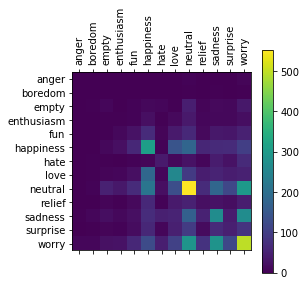

In [19]:
y_pred = model.predict(X_test_bow)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.matshow(cm)
plt.colorbar()

tick_marks = np.arange(len(emotions))
classes = sorted(emotions.keys(), key=lambda x: emotions[x])
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)